In [2]:
from os import environ
from pathlib import Path
from json import loads, dumps
environ["OPENAI_API_KEY"] = Path("~/.openaiapikey").expanduser().read_text().strip()

In [3]:
from openai import OpenAI
from random import randint

openaiClient = OpenAI()
def gpt_3_5_turbo_completion(query):
    answer = openaiClient.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": query
            }
        ],
        seed = randint(0, 1000000)
    )
    return answer.choices[0].message.content

def gpt_4_turbo_completion(query):
    answer = openaiClient.chat.completions.create(
        model="gpt-4-turbo",
        messages=[
            {
                "role": "system",
                "content": query
            }
        ],
        seed = randint(0, 1000000)
    )
    return answer.choices[0].message.content

def tryRecieveAnswer(query, completionFunction = gpt_4_turbo_completion, answerConversion = lambda x: True, maxTries = 10):
    tryNumber = 0
    while tryNumber < maxTries:
        answer = completionFunction(query)
        try:
            answer = answerConversion(answer)
            return (answer, True)
        except:
            pass
        tryNumber += 1
    print(f"Failed to recieve answer for query: {query}")
    return (None, False)

In [9]:
def isSynonym(term1, term2):
    query = f'''
            The same concept can be discribed by differend words. For example, the terms "Earth", "The earth", "Planet Earth" and "Our Planet" all refer to the same thing. 
            On the other hand, similar sounding terms like "Star" and "Stars", "Water" and "Boiling Water" or "Time" and "Minute" refer to different things.
            Are the terms "{term1}" and "{term2}" synonyms? Respond only with y or n without explanation.'''
    def answerConversion(answer):
        assert answer.lower().strip() in ["y", "n"]
        return answer.lower().strip() == "y"
    answer, success = tryRecieveAnswer(query, answerConversion = answerConversion)
    return answer

In [11]:
isSynonym("A Moon", "Our Moon")

False

In [22]:
def findSynonyms(term):
    query = f'''
            The same concept can be discribed by differend words. For example, the terms "Earth", "The earth", "Planet Earth" and "Our Planet" all refer to the same thing. 
            On the other hand, similar sounding terms like "Star" and "Stars", "Water" and "Boiling Water" or "Time" and "Minute" refer to different things.
            Give me some terms, that describe the same concept as "{term}". Include only terms where the equality is completely clear.
            Return them in a list formatted as ["term1", "term2", ...]. Return nothing but the list.'''
    def answerConversion(answer):
        result = loads(answer)
        assert isinstance(result, list)
        for term in result:
            assert isinstance(term, str)
        return result
    answer, success = tryRecieveAnswer(query, answerConversion = answerConversion)
    return answer

In [25]:
findSynonyms("Car")

['Automobile', 'Vehicle', 'Motorcar', 'Auto']

In [17]:
def findSynonymsFromTheSellection(term, sellection):
    enumeratedSelectionString = ", ".join([f'{i+1}. "{term}"' for i, term in enumerate(sellection)])
    query = f'''
            The same concept can be discribed by differend words. For example, the terms "Earth", "The earth", "Planet Earth" and "Our Planet" all refer to the same thing. 
            On the other hand, similar sounding terms like "Star" and "Stars", "Water" and "Boiling Water" or "Time" and "Minute" refer to different things.
            Are there any synonyms for the term "{term}" in the following list: {enumeratedSelectionString}?
            Return the indices of all synonyms in the selection formatted as [index1, index2, ...]. Return nothing but this list. Return an empty list if there are no synonyms.'''
    def answerConversion(answer):
        result = loads(answer)
        assert isinstance(result, list)
        for index in result:
            assert isinstance(index, int)
            assert 0 < index <= len(sellection)
        return [sellection[index - 1] for index in result]
    answer, success = tryRecieveAnswer(query, answerConversion = answerConversion)
    return answer

In [19]:
findSynonymsFromTheSellection("Rocket", ["Spaceship", "Plane", "Rocket", "Car", "Bike"])

['Spaceship', 'Rocket']

In [47]:
def findNewTerms(topic, number = 20):
    query = f'''
            The concepts "Stellar evolution", "Brownian motion", "Center of mass" and "Optics" are all part of the topic "Physics".
            Give me a selection of {number} specific concepts that belong to subtopics of the topic "{topic}".
            Return them in a list formatted as ["concept1", "concept2", ...]. Return nothing but the list.'''
    def answerConversion(answer):
        result = loads(answer)
        assert isinstance(result, list)
        for concept in result:
            assert isinstance(concept, str)
        return result
    answer, success = tryRecieveAnswer(query, answerConversion = answerConversion)
    return answer

In [43]:
terms = findNewTerms("Physics", 5)
print(terms)

['Black holes', 'Quantum entanglement', 'Refraction', 'Thermodynamics', 'Electromagnetic waves']


In [44]:
def addAdditionalTerms(termlist, topic, number = 20):
    termString = "[" + ", ".join([f'"{term}"' for term in termlist]) + "]"
    query = f'''
            The concepts {termString} are all part of the topic "{topic}".
            Give me a selection of {number} new concepts that belong to subtopics of the topic "{topic}".
            Return them in a list formatted as ["concept1", "concept2", ...]. Return nothing but the list.'''
    def answerConversion(answer):
        result = loads(answer)
        assert isinstance(result, list)
        for concept in result:
            assert isinstance(concept, str)
        return result
    answer, success = tryRecieveAnswer(query, answerConversion = answerConversion)
    return answer

In [52]:
from random import shuffle
def getLongTermList(topic, number = 20, iterations = 5, oldTerms = []):
    terms = findNewTerms(topic, number) if not oldTerms else oldTerms
    for i in range(iterations):
        shuffledTerms = list(set(terms))
        shuffle(shuffledTerms)
        if len(shuffledTerms) > 20:
            shuffledTerms = shuffledTerms[:20]
        terms += addAdditionalTerms(shuffledTerms, topic, number)
    return terms

In [64]:
termlistFile = Path("termlist2.json")
if termlistFile.exists():
    longTermList = loads(termlistFile.read_text())
longTermList = getLongTermList("Physics", 5, 30, longTermList)
termlistFile.write_text(dumps(longTermList, indent = 4))

10281

In [54]:
def listMostUsedConceptsOfTermList(termlist):
    countedTerms = {}
    for term in termlist:
        if term in countedTerms:
            countedTerms[term] += 1
        else:
            countedTerms[term] = 1
    return sorted(countedTerms.items(), key = lambda x: x[1], reverse = True)

In [55]:
# Print the top 20 most used concepts of the long term list
termlistFile = Path("termlist.json")
longTermList = loads(termlistFile.read_text())
mostUsedConcepts = listMostUsedConceptsOfTermList(longTermList)
for concept, count in mostUsedConcepts[:20]:
    print(f"{concept}: {count}")

Superconductivity: 8
Quantum field theory: 7
Quantum entanglement: 6
Nuclear fusion: 6
Thermodynamics: 5
String theory: 5
Higgs boson: 5
Quantum computing: 5
Dark matter: 5
Electromagnetism: 5
Particle physics: 4
Photonics: 4
Black holes: 4
Relativity: 3
Wave-particle duality: 3
General relativity: 3
Quantum chromodynamics: 3
Gravitational waves: 3
Condensed matter physics: 3
Chaos theory: 3


In [57]:
# Count the percentage of unique concepts in the long term list
termlistFile = Path("termlist.json")
longTermList = loads(termlistFile.read_text())
countedTerms = listMostUsedConceptsOfTermList(longTermList)
totalConcepts = len(countedTerms)
uniqueConcepts = len([count for concept, count in countedTerms if count == 1])
percentageUnique = uniqueConcepts / totalConcepts * 100
print(f"Percentage of unique concepts: {percentageUnique}%")

Percentage of unique concepts: 51.388888888888886%


In [62]:
# Plot the number of different concepts depending on the number of generated concepts
# Add the diagonal line to the plot as dashed line
def plotNumberOfDifferentConcepts(longTermList):
    import matplotlib.pyplot as plt
    numbersOfDifferentConcepts = []
    for i in range(len(longTermList)):
        numberOfDifferentConcepts = len(set(longTermList[:i]))
        numbersOfDifferentConcepts.append(numberOfDifferentConcepts)
    plt.plot([i for i in range(len(longTermList))], linestyle = "--", color = "lightgrey")
    plt.plot(numbersOfDifferentConcepts)
    plt.xlabel("Number of generated concepts")
    plt.ylabel("Number of different concepts")
    plt.show()

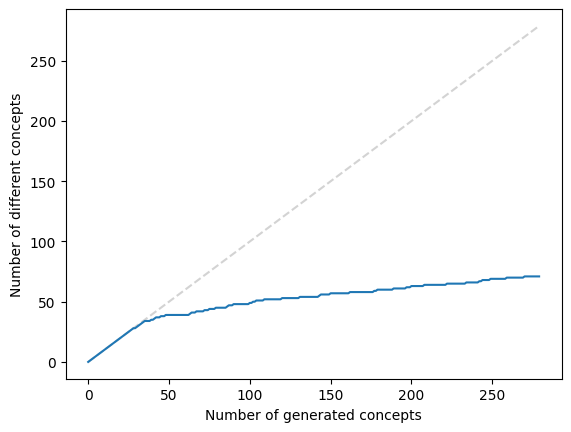

In [63]:
plotNumberOfDifferentConcepts(longTermList)

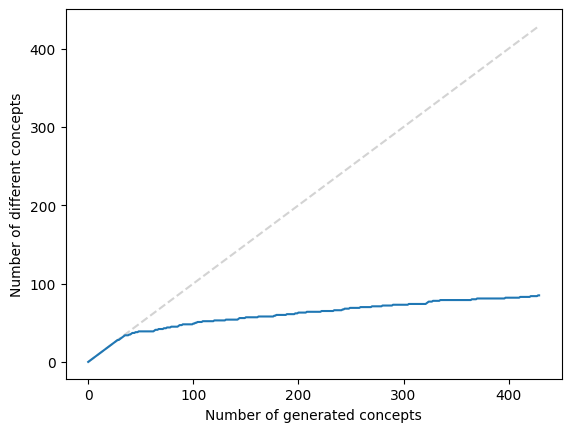

In [65]:
longTermList2 = loads(Path("termlist2.json").read_text())
plotNumberOfDifferentConcepts(longTermList2)